In [8]:
!pip install numpy
!pip install pandas
!pip install openpyxl
!pip install nltk
!pip install sklearn
!pip install fasttext
!pip install wordcloud

You should consider upgrading via the '/home/danial/PycharmProjects/MIR-HWs3-5/venv/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/danial/PycharmProjects/MIR-HWs3-5/venv/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/danial/PycharmProjects/MIR-HWs3-5/venv/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/danial/PycharmProjects/MIR-HWs3-5/venv/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/danial/PycharmProjects/MIR-HWs3-5/venv/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/danial/PycharmProjects/MIR-HWs3-5/venv/bin/python -m pip install --upgrade pip' command.
     |████████████████████████████████| 458 kB 564 kB/s eta 0:00:01
     |████████████████████████████████| 11.2 MB 1.2 MB/s eta 0:00:01
     |████████████████████████████████| 3.1 MB 10.1 MB/s et

In [1]:
import os
import numpy as np
import nltk
import pandas as pd

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /home/danial/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/danial/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
dfs = []
for file in os.listdir("./Excels"):
    df = pd.read_excel(os.path.join("./Excels", file))
    dfs.append(df)
    print(file, end=": ")
    print(df.shape)
df = pd.concat(dfs)

WWDC.xlsx: (2080, 19)
spaceX.xlsx: (2010, 19)
Google.xlsx: (2051, 19)
Meta.xlsx: (1644, 19)
metaverse.xlsx: (1553, 19)
tech.xlsx: (2076, 19)
Apple.xlsx: (2031, 19)
instagram.xlsx: (1949, 19)
Microsoft.xlsx: (2080, 19)
science.xlsx: (2080, 19)
Twitter.xlsx: (1616, 19)
facebook.xlsx: (2027, 19)
Amazon.xlsx: (2078, 19)
robots.xlsx: (1982, 19)
nvidia.xlsx: (2010, 19)
Tesla.xlsx: (2004, 19)


In [3]:
df.columns, df.shape

(Index(['Tweet Id', 'Text', 'Name', 'Screen Name', 'UTC', 'Created At',
        'Favorites', 'Retweets', 'Language', 'Client', 'Tweet Type', 'URLs',
        'Hashtags', 'Mentions', 'Media Type', 'Media URLs', 'Unnamed: 16',
        'Unnamed: 17', 'Unnamed: 18'],
       dtype='object'),
 (31271, 19))

In [4]:
df = df[df['Language'] == 'en']
df.reset_index(drop=True, inplace=True)

In [5]:
df.drop_duplicates(subset="Text", keep='first', inplace=True, ignore_index=False)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12665 entries, 0 to 21001
Data columns (total 19 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Tweet Id     12665 non-null  int64 
 1   Text         12665 non-null  object
 2   Name         12665 non-null  object
 3   Screen Name  12665 non-null  object
 4   UTC          12665 non-null  object
 5   Created At   12665 non-null  object
 6   Favorites    12665 non-null  int64 
 7   Retweets     12665 non-null  int64 
 8   Language     12665 non-null  object
 9   Client       12665 non-null  object
 10  Tweet Type   12665 non-null  object
 11  URLs         7151 non-null   object
 12  Hashtags     12665 non-null  int64 
 13  Mentions     12665 non-null  int64 
 14  Media Type   5619 non-null   object
 15  Media URLs   5619 non-null   object
 16  Unnamed: 16  598 non-null    object
 17  Unnamed: 17  379 non-null    object
 18  Unnamed: 18  244 non-null    object
dtypes: int64(5), object(14)
m

In [7]:
from nltk.corpus import stopwords
import re
def text_to_words(text):
    text = text.lower()
    text = re.sub(
    "(https?://(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?://(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,})",
    "", text)
    text = re.sub("#\w+", "", text)
    text = re.sub("@\w+", "", text)
    words = nltk.word_tokenize(text)
    words = [word for word in words if word not in stopwords.words('english') and word.isalpha()]
    return words
df['Text_words'] = df['Text'].apply(text_to_words)

In [48]:
df['Text_words'].explode().value_counts().reset_index().head(30)

,index,Text_words
0,rt,3921
1,new,1034
2,amp,999
3,science,972
4,robots,768
5,us,677
6,like,547
7,apple,513
8,gt,492
9,via,484


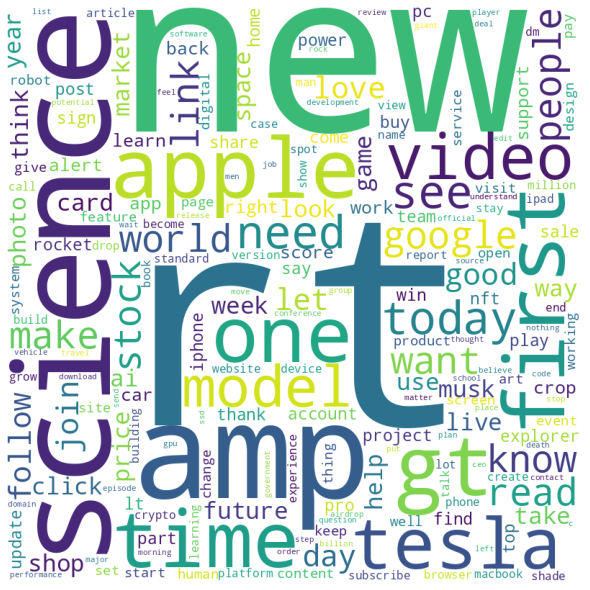

In [55]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

all_words = " ".join(set(df['Text_words'].explode()) - {np.nan})
all_words = " ".join(df['Text_words'].explode().value_counts().reset_index()['index'])
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10).generate(all_words)
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

In [26]:
nltk.FreqDist(df['Text_words'].explode()).most_common(20)

[('rt', 3921),
 ('new', 1034),
 ('amp', 999),
 ('science', 972),
 ('robots', 768),
 ('us', 677),
 ('like', 547),
 ('apple', 513),
 ('gt', 492),
 ('via', 484),
 ('first', 473),
 ('time', 469),
 ('get', 468),
 ('one', 440),
 ('rtx', 416),
 ('tesla', 414),
 ('video', 367),
 ('geforce', 364),
 ('model', 316),
 ('free', 311)]

In [30]:
import pandas as pd
import numpy as np
import re
from sklearn.feature_extraction.text import TfidfVectorizer

class TFIDFSearch:
    def __init__(self):
        self.vocabulary = list(set(df['Text_words'].explode()) - {np.nan})

        self.tfidf = TfidfVectorizer(vocabulary=self.vocabulary)
        self.tfidf_tran=self.tfidf.fit_transform(df['Text_words'].apply(lambda x: ' '.join(x)))

    def get_vector(self, tokens):
        result = np.zeros((len(self.vocabulary)))
        x= self.tfidf.transform(tokens)
        for token in tokens:
            try:
                ind = self.vocabulary.index(token)
                result[ind]  = x[0, self.tfidf.vocabulary_[token]]
            except Exception as e:
                print(e)
                pass
        return result

    @staticmethod
    def cosine_sim(a, b):
        norm_a = np.linalg.norm(a)
        norm_b = np.linalg.norm(b)
        if norm_a == 0 or norm_b == 0:
            return 0
        cos_sim = np.dot(a, b)/(norm_a*norm_b)
        return cos_sim

    def search(self, k, query):
        tokens = text_to_words(query)
        print(tokens)
        q_df = pd.DataFrame(columns=['q_clean'])
        q_df.loc[0, 'q_clean'] = tokens

        d_cosines = []

        query_vector = self.get_vector(tokens)
        for d in self.tfidf_tran.A:
            d_cosines.append(self.cosine_sim(query_vector, d))

        out = np.array(d_cosines).argsort()[-k:][::-1]
        a = pd.DataFrame()
        for i, index in enumerate(out):
            a.loc[i, 'index'] = str(index)
            a.loc[i, 'text'] = df.iloc[index]['Text']
            a.loc[i, 'words'] = str(df.iloc[index]['Text_words'])
            a.loc[i, 'Score'] = d_cosines[int(index)]
        return a

In [31]:
model = TFIDFSearch()
results = model.search(10, "elon musk")
results

/Users/kian/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:1322: UserWarning: Upper case characters found in vocabulary while 'lowercase' is True. These entries will not be matched with any documents
  warnings.warn(


['elon', 'musk']


,index,text,words,Score
0,7323,@SpaceX + @DogelonMars = 🚀\n\n@elonmusk Don't...,['elon'],1.000000
1,7319,RT @ElonMartians : @SpaceX + @DogelonMars = 🚀\...,"['rt', 'elon']",0.924041
2,12610,@elonmusk @elonamuskjet @ElonMuskNewsOrg @Tesl...,"['elon', 'spacex']",0.688690
3,7542,"RT @Dyoungelonhero : Elon,Send #GalaxyHeroes t...","['rt', 'elon', 'send']",0.620838
4,7523,In Elon We Trust! ❤️🙏🏼 #dogecoin #tesla #Spac...,"['elon', 'trust']",0.597168
5,11895,Could Elon Musk be a thief? Elon Musk why don'...,"['could', 'elon', 'musk', 'thief', 'elon', 'mu...",0.516056
6,7296,Elon Musk replied to @Rainmaker1973 #SpaceX ht...,"['elon', 'musk', 'replied']",0.511267
7,7559,Elon Musk replied to @SirineAti #SpaceX https:...,"['elon', 'musk', 'replied']",0.511267
8,7554,Elon Musk replied to @elonmusk #SpaceX https:/...,"['elon', 'musk', 'replied']",0.511267
9,7545,Elon Musk replied to @Erdayastronaut #SpaceX h...,"['elon', 'musk', 'replied']",0.511267


In [32]:
for i, res in enumerate(results.text):
    print(f"{i}: ")
    print(res, end="\n\n")

0: 
@SpaceX + @DogelonMars = 🚀

@elonmusk  Don't You Think❓

$Elon 🔝

#dogelon #dogelonmars #Elon
#SpaceX #ToTheMars🚀
#MultiPlanetarySpecies 
#MultiPlanetaryCurrency

1: 
RT @ElonMartians : @SpaceX + @DogelonMars = 🚀

@elonmusk  Don't You Think❓

$Elon 🔝

#dogelon #dogelonmars #Elon
#SpaceX #ToTheMars🚀
#MultiPlanetarySpecies 
#MultiPlanetaryCurrency

2: 
@elonmusk @elonamuskjet @ElonMuskNewsOrg @Tesla @teslacn @teslaownersSV @SpaceX @SpaceXStarlink @spacex360 #Tesla Elon SpaceX #Tesla #ElonMusk https://t.co/6oNPBUrppo

3: 
RT @Dyoungelonhero : Elon,Send #GalaxyHeroes to Mars！！ 
@elonmusk #ElonMusk
#SpaceX
https://t.co/KUGbk9Jhjz

4: 
In Elon We Trust! ❤️🙏🏼  #dogecoin #tesla #SpaceX https://t.co/ydIzwj93Me

5: 
Could Elon Musk be a thief? Elon Musk why don't you pay my share?
#ElonMusk #Tesla #Texas #USA #Warriors #CIA #FBI #AttorneyJobs #FoxNews #ABC #CNBC #War #WarCrime #War #Peace #lordbenariel #mylove #Lord #justice #business @elonmusk @ABC @WhiteHouse @FBI
https://t.co/NCsve1y7gd



In [97]:
class BooleanSearch:
    def __init__(self):
        self.vocabulary = list(set(df['Text_words'].explode()) - {np.nan})
        self.vocabulary_index = {word: idx for idx, word in enumerate(self.vocabulary)}

        self.mat = np.zeros((len(df), len(self.vocabulary)), )

        for index, row in df.iterrows():
            for token in row['Text_words']:
                self.mat[index][self.vocabulary_index[token]] = 1


    def search(self, k, query):
        #print("Cosine Similarity")
        tokens = text_to_words(query)
        query_vector = []
        for token in tokens:
            if token in self.vocabulary_index:
                query_vector.append(self.vocabulary_index[token])
        out = []
        for index, vec in enumerate(self.mat):
            flag = True
            for token_index in query_vector:
                if vec[token_index] == 0:
                    flag = False
                    break
            if flag:
                out.append(index)
            if len(out) == k:
                break
        print(out)
        a = pd.DataFrame()
        for i, index in enumerate(out):
            a.loc[i, 'index'] = str(index)
            a.loc[i, 'text'] = df.iloc[index]['Text']
            a.loc[i, 'words'] = str(df.iloc[index]['Text_words'])

        return a

In [98]:
model = BooleanSearch()
model.search(10, "Elon Musk")

[22, 93, 350, 1495, 1517, 1531, 1543, 1547, 1548, 1549]


,index,text,words
0,22,Elon Musk give me MONEY bitch And don't forge...,"['elon', 'musk', 'give', 'money', 'bitch', 'fo..."
1,93,"Elon Musk give me $10,000 AND Putin a giant s...","['elon', 'musk', 'give', 'putin', 'giant', 'sp..."
2,350,"Elon Musk give me $99,000 AND Putin elegant a...","['elon', 'musk', 'give', 'putin', 'elegant', '..."
3,1495,what if Gerald Cotten is Elon Musk (:)\n@elonm...,"['gerald', 'cotten', 'elon', 'musk', 'musk']"
4,1517,Elon Musk's SpaceX has cleared a huge obstacle...,"['elon', 'musk', 'spacex', 'cleared', 'huge', ..."
5,1531,How China could kill Space X.\nSpace X's space...,"['china', 'could', 'kill', 'space', 'space', '..."
6,1543,RT @weatherindia : Elon Musk's #SpaceX has rec...,"['rt', 'elon', 'musk', 'received', 'environmen..."
7,1547,RT @TweakTown : Elon Musk says @SpaceX's Stars...,"['rt', 'elon', 'musk', 'says', 'starship', 'ro..."
8,1548,RT @TweakTown : Elon Musk says @SpaceX's Stars...,"['rt', 'elon', 'musk', 'says', 'starship', 'ro..."
9,1549,RT @TweakTown : Elon Musk says @SpaceX's Stars...,"['rt', 'elon', 'musk', 'says', 'starship', 'ro..."


In [90]:
import fasttext.util

class FastText:
    def __init__(self):
        fasttext.util.download_model('en', if_exists='ignore')  # English
        self.ft = fasttext.load_model("./cc.en.300.bin")
        self.text_vectors = []
        for _, row in df.iterrows():
            self.text_vectors.append(self.tokens_to_vec(row['Text_words']))

    def tokens_to_vec(self, tokens):
        cur_vectors = []
        if len(tokens) == 0:
            return np.zeros(self.ft.get_dimension())
        for token in tokens:
            cur_vectors.append(self.ft.get_word_vector(token))
        return np.asarray(np.average(cur_vectors, axis=0, keepdims=True))[0]

    @staticmethod
    def cosine_sim(a, b):
        norm_a = np.linalg.norm(a)
        norm_b = np.linalg.norm(b)
        if norm_a == 0 or norm_b == 0:
            return 0
        cos_sim = np.dot(a, b)/(norm_a*norm_b)
        return cos_sim

    def search(self, k, query):
        tokens = text_to_words(query)
        query_vector = self.tokens_to_vec(tokens)
        d_cosines = []

        for d in self.text_vectors:
            d_cosines.append(self.cosine_sim(d, query_vector))

        out = np.array(d_cosines).argsort()[-k:][::-1]
        a = pd.DataFrame()
        for i, index in enumerate(out):
            a.loc[i, 'index'] = str(index)
            a.loc[i, 'text'] = df.iloc[index]['Text']
            a.loc[i, 'words'] = str(df.iloc[index]['Text_words'])
            a.loc[i, 'Score'] = d_cosines[int(index)]
        return a

In [91]:
amo = FastText()
amo.search(10, "Elon musk")

,index,text,words,Score
0,2223,Elon Musk replied to @SpaceX #SpaceX https://t...,"['elon', 'musk', 'replied']",0.978804
1,2161,Elon Musk replied to @Erdayastronaut #SpaceX h...,"['elon', 'musk', 'replied']",0.978804
2,2174,Elon Musk replied to @elonmusk #SpaceX https:/...,"['elon', 'musk', 'replied']",0.978804
3,2181,Elon Musk replied to @SirineAti #SpaceX https:...,"['elon', 'musk', 'replied']",0.978804
4,2206,Elon Musk replied to @DJSnM #SpaceX https://t....,"['elon', 'musk', 'replied']",0.978804
5,1780,Elon Musk replied to @Rainmaker1973 #SpaceX ht...,"['elon', 'musk', 'replied']",0.978804
6,14423,what if Gerald Cotten is Elon Musk (:)\n@elonm...,"['gerald', 'cotten', 'elon', 'musk', 'musk']",0.965241
7,1495,what if Gerald Cotten is Elon Musk (:)\n@elonm...,"['gerald', 'cotten', 'elon', 'musk', 'musk']",0.965241
8,14980,🔥👽 Episode 87 of Elon Musk Radio!\n\nTwitter: ...,"['episode', 'elon', 'musk', 'radio', 'twitter'...",0.929618
9,14730,Could Elon Musk be a thief? Elon Musk why don'...,"['could', 'elon', 'musk', 'thief', 'elon', 'mu...",0.916916
